<a href="https://colab.research.google.com/github/rafaellabastos/savvyfix-ia-notebook/blob/rafaella/precificacao_dinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SavvyFix - Precificação dinâmica**

<p>2TDSPF</p>

<p>Douglas Magalhães de Araujo - 552008</p>
<p>Erik Yuuzo Kobayachi Yamada - 98027</p>
<p>Gustavo Argüello Bertacci - 551304</p>
<p>Luiz Fillipe Farias - 99519</p>
<p>Rafaella Monique do Carmo Bastos - 552425</p>

# **Dataset**

<p>Dataset presente na raíz do repositório no Github com o nome "datasetIA.xlsx" ou no link: https://docs.google.com/spreadsheets/d/1gtDX6f2rMFc6DH8Rad0Lq-MZ4yDYK8T2/edit?usp=drive_link&ouid=102116052499151495625&rtpof=true&sd=true</p>

<br>

## Descrição da base de dados utilizada
<p>A base de dados utilizada diz respeito às informações coletadas por meio dos cookies sobre as informações de cada cliente, sejam informações fixas (nome e produto), sobre seu atual estado (localização, horário e clima) ou informações sobre a utilização do site (procura e demanda).</p>
<br>
<p><b>1.  Nome:</b> a coluna “Nome” indica o nome completo do usuário que está cadastrado no sistema.</p>
<p><b>2. Produto:</b> a coluna “Produto” indica o nome do produto vendido no site que será utilizado para determinar o preço dinâmico para determinado usuário.</p>
<p><b>3. Localização:</b> a coluna “Localização” indica o estado que o usuário está quando ele visitou o site no formato de siglas.</p>
<p><b>4. Horário:</b> a coluna “Horário” indica o horário no momento que o usuário entrou no site no formato hh:mm.</p>
<p><b>5. Clima:</b> a coluna “Clima” indica o clima no momento que o usuário entrou no site no formato de número.</p>
<p><b>6. Procura:</b> a coluna “Procura” indica a quantidade de vezes que o usuário procurou por aquele produto em um dia.</p>
<p><b>7. Demanda:</b> a coluna “Demanda” indica se, no geral, um produto está com procura alta, média ou baixa.</p>


## **Protótipo Funcional**

<b>Importação das bibliotecas</b>

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

<b>Tratamento e visualização do dataset</b>

In [25]:
# Carregando o dataset
df = pd.read_excel('datasetIA.xlsx', sheet_name='Planilha1')

# Corrigindo o nome da coluna com espaço extra
df.columns = df.columns.str.strip()

# Tratando valores nulos
df = df.fillna({'Localização': 'Desconhecido', 'Horário': '00:00:00', 'Clima': 0, 'Procura': 0, 'Demanda': 'Desconhecido'})

## Exclusão de temperaturas abaixo de 0º
df['Clima'] = pd.to_numeric(df['Clima'], errors='coerce')
df_new = df[(df['Clima'] >= 0) & (df['Clima'].notna())]


# Visualização do dataset
print(df_new.head())

                      Nome     Produto Localização   Horário  Clima  Procura  \
1  Pedro Henrique Oliveira    Converse          PR  18:23:00   25.0     24.0   
2    Maria Fernanda Santos      Oakley          AP  02:38:00   30.0     24.0   
4    Carla Rodrigues Costa  Piccadilly          SC  04:39:00   32.0     26.0   
5    Lucas Gabriel Pereira      Colcci          RR  22:06:00   40.0     27.0   
6    Juliana Martins Souza        Vans          TO  10:23:00   28.0     15.0   

  Demanda  
1   Baixa  
2   Média  
4    Alta  
5    Alta  
6    Alta  


<b>Implementação da precificação dinâmica</b>

In [26]:
# Definição das porcentagens de acordo com cada critério
porcentagem_localizacao = {
    'RS': 0.02, 'SC': 0.02, 'PR': 0.01, 'SP': 0.02, 'RJ': 0.02, 'ES': 0,
    'MG': 0, 'MT': -0.01, 'MS': -0.01, 'GO': -0.01, 'AM': -0.02, 'AC': -0.02,
    'RO': -0.02, 'RR': -0.02, 'AP': -0.02, 'PA': 0, 'TO': -0.01, 'MA': 0,
    'PI': -0.01, 'BA': 0.02, 'CE': 0.01, 'RN': -0.01, 'SE': -0.02, 'AL': 0,
    'PE': 0.01, 'PB': -0.02, 'Desconhecido': 0
}

porcentagem_horario = {
    '00h-00h59': -0.01, '01h-01h59': -0.02, '02h-02h59': -0.02, '03h-03h59': -0.02,
    '04h-04h59': -0.02, '05h-05h59': -0.01, '06h-06h59': -0.01, '07h-07h59': 0,
    '08h-08h59': 0, '09h-09h59': 0.01, '10h-10h59': 0.01, '11h-11h59': 0.02,
    '12h-12h59': 0.02, '13h-13h59': 0.01, '14h-14h59': 0.01, '15h-15h59': 0,
    '16h-16h59': 0, '17h-17h59': 0, '18h-18h59': 0.01, '19h-19h59': 0.01,
    '20h-20h59': 0.02, '21h-21h59': 0.01, '22h-22h59': 0, '23h-23h59': 0
}

porcentagem_clima = {
    '1º a 5º': 0.01, '6º a 10º': 0.02, '11º a 15º': -0.02, '16º a 19º': -0.01,
    '20º a 23º': 0, '24º a 26º': 0, '27º a 29º': 0.01, '30º a 34º': 0.01,
    '35º a 39º': 0.02, '+40º': 0.02
}

porcentagem_procura = {
    '1x': 0, '2 a 3x': 0.003, '4 a 7x': 0.008, '8 a 13x': 0, '14 a 17x': -0.002,
    '17 a 20x': 0.001, '+21x': 0, 'Desconhecido': 0
}

porcentagem_demanda = {
    'Alta': 0.02, 'Média': 0, 'Baixa': -0.01, 'Desconhecido': 0
}

def calcular_variacao(row):
    try:
        preco_base = 100

        # Variação por localização
        variacao_localizacao = porcentagem_localizacao.get(row['Localização'], 0)

        # Variação por horário
        horario = str(row['Horário']).strip()
        hora = int(horario.split(':')[0])
        faixa_horaria = f"{hora:02d}h-{hora:02d}h59"
        variacao_horario = porcentagem_horario.get(faixa_horaria, 0)

        # Variação por clima
        try:
            clima = int(row['Clima'])
        except ValueError:
            clima = 0
        variacao_clima = 0
        for faixa, variacao in porcentagem_clima.items():
            if faixa.startswith('+') or faixa.startswith('-'):
                limites = faixa.split('º a ')
                if len(limites) == 2:
                    limite_inferior = int(limites[0].replace('º', ''))
                    limite_superior = int(limites[1].replace('º', ''))
                    if limite_inferior <= clima <= limite_superior:
                        variacao_clima = variacao
                        break
                else:
                    limite_inferior = int(limites[0].replace('+', '').replace('º', ''))
                    if clima >= limite_inferior:
                        variacao_clima = variacao
                        break
            else:
                if faixa == f'{clima}':
                    variacao_clima = variacao
                    break

        # Variação por procura
        procura = str(row['Procura']).strip()
        variacao_procura = porcentagem_procura.get(procura, 0)

        # Variação por demanda
        variacao_demanda = porcentagem_demanda.get(row['Demanda'], 0)

        # Calculando o novo preço com base nas variações
        preco_final = preco_base * (1 + variacao_localizacao + variacao_horario +
                                    variacao_clima + variacao_procura + variacao_demanda)

        return preco_final
    except Exception as e:
        print(f"Erro ao processar a linha: {row}. Erro: {e}")
        return None

# Aplicando a função ao dataset
df_new['Preço Final'] = df_new.apply(calcular_variacao, axis=1)

# Verificando se tem algum problema na atribuição dos dados
print(df_new[['Nome', 'Produto', 'Localização', 'Horário', 'Clima', 'Procura', 'Demanda', 'Preço Final']].head())



                      Nome     Produto Localização   Horário  Clima  Procura  \
1  Pedro Henrique Oliveira    Converse          PR  18:23:00   25.0     24.0   
2    Maria Fernanda Santos      Oakley          AP  02:38:00   30.0     24.0   
4    Carla Rodrigues Costa  Piccadilly          SC  04:39:00   32.0     26.0   
5    Lucas Gabriel Pereira      Colcci          RR  22:06:00   40.0     27.0   
6    Juliana Martins Souza        Vans          TO  10:23:00   28.0     15.0   

  Demanda  Preço Final  
1   Baixa        101.0  
2   Média         96.0  
4    Alta        102.0  
5    Alta        102.0  
6    Alta        102.0  


<ipython-input-26-9d64bf8d2b3c>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Preço Final'] = df_new.apply(calcular_variacao, axis=1)


<b>Dados de treino e teste</b>

In [27]:
# Separando as variáveis independentes e dependentes
X = df_new[['Localização', 'Horário', 'Clima', 'Procura', 'Demanda']]
y = df_new['Preço Final']

# Convertendo variáveis categóricas em variáveis dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificando a divisão
print(f"Tamanho do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treinamento: (643, 655)
Tamanho do conjunto de teste: (161, 655)


## **Análise da curva ABC**

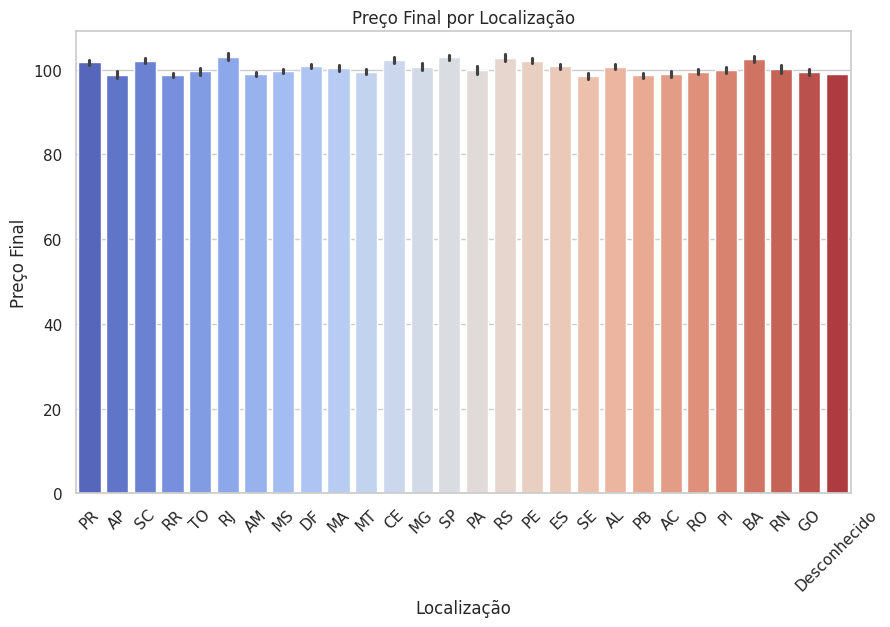

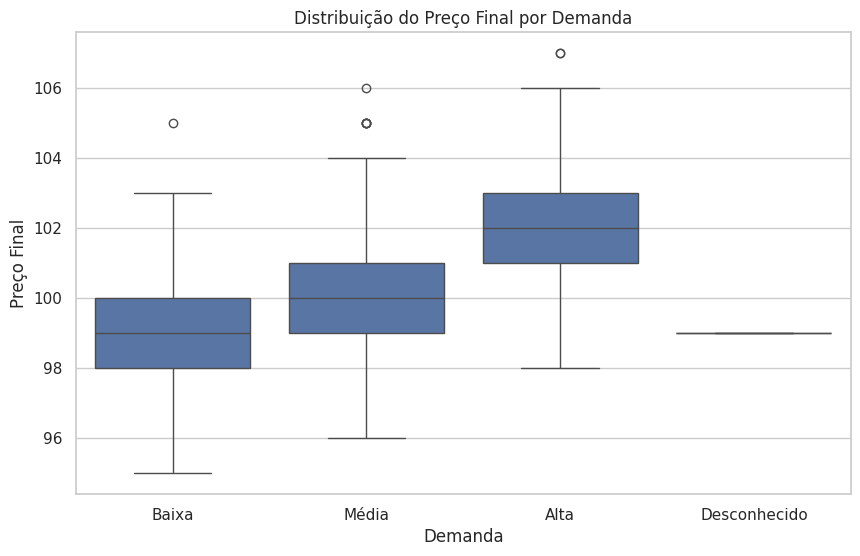

In [31]:
# Configurando para gráficos mais bonitos
sns.set(style="whitegrid")

# Gráfico de Barras: Preço Final por Localização
plt.figure(figsize=(10, 6))
sns.barplot(x="Localização", y="Preço Final", data=df_new, palette="coolwarm", hue="Localização")
plt.title("Preço Final por Localização")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)
plt.show()


# Boxplot: Preço Final por Nível de Demanda
plt.figure(figsize=(10, 6))
sns.boxplot(x="Demanda", y="Preço Final", data=df_new)
plt.title("Distribuição do Preço Final por Demanda")
plt.show()